<a href="https://colab.research.google.com/github/fjadidi2001/Image_Inpaint/blob/main/NextGen_Jan2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Load Image

Saving Mona_Lisa.jpg to Mona_Lisa.jpg


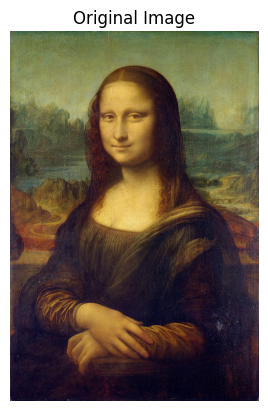

In [1]:
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt

# Upload the file
uploaded = files.upload()

# Open the image using PIL
image = Image.open('Mona_Lisa.jpg')

# Display the image
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.title('Original Image')
plt.show()

Step 2: Preprocess Image


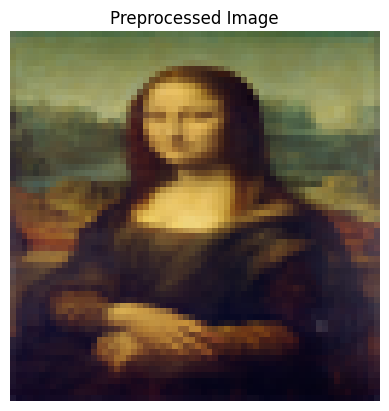

In [2]:
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array

# Resize and normalize the image
image = image.resize((64, 64))  # Resize to 64x64
image = img_to_array(image)  # Convert to numpy array
image = (image - 127.5) / 127.5  # Normalize to [-1, 1]

# Display the preprocessed image
plt.imshow((image + 1) / 2)  # Rescale to [0, 1] for display
plt.axis('off')
plt.title('Preprocessed Image')
plt.show()

# Step 3: Create Mask


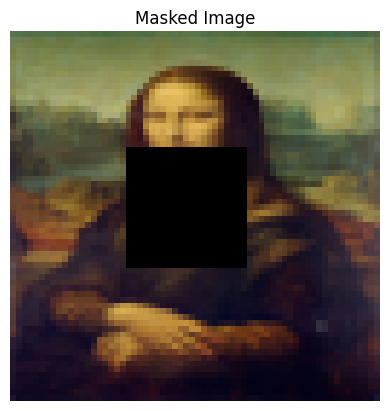

In [3]:
from PIL import ImageDraw

# Create a copy of the image to draw on
masked_image = Image.fromarray(((image + 1) * 127.5).astype(np.uint8))

# Define the square's position and size (left, upper, right, lower)
left = 20
upper = 20
right = 40
lower = 40

# Draw the mask (a filled rectangle) on the image
draw = ImageDraw.Draw(masked_image)
draw.rectangle([left, upper, right, lower], fill=(0, 0, 0))  # Black mask

# Convert back to numpy array and normalize
masked_image = img_to_array(masked_image)
masked_image = (masked_image - 127.5) / 127.5

# Display the masked image
plt.imshow((masked_image + 1) / 2)
plt.axis('off')
plt.title('Masked Image')
plt.show()

# Step 4: Define Model


In [5]:
from tensorflow.keras import layers, models

# Define the Generator
def build_generator(latent_dim):
    model = models.Sequential()

    # Start with a dense layer
    model.add(layers.Dense(8 * 8 * 256, input_dim=latent_dim))
    model.add(layers.Reshape((8, 8, 256)))

    # Upsample to 16x16
    model.add(layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Upsample to 32x32
    model.add(layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Upsample to 64x64
    model.add(layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', activation='tanh'))

    return model

# Define the Discriminator
def build_discriminator(img_shape):
    model = models.Sequential()

    # Input layer
    model.add(layers.Conv2D(64, kernel_size=4, strides=2, padding='same', input_shape=img_shape))
    model.add(layers.LeakyReLU(alpha=0.2))

    # Downsample to 16x16
    model.add(layers.Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Downsample to 8x8
    model.add(layers.Conv2D(256, kernel_size=4, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Output layer
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

# Parameters
latent_dim = 100
img_shape = (64, 64, 3)

# Build models
generator = build_generator(latent_dim)
discriminator = build_discriminator(img_shape)

# Step 5: Combine DCGAN Model


In [6]:
from tensorflow.keras.optimizers import Adam

# Define the GAN
def build_gan(generator, discriminator):
    discriminator.trainable = False  # Freeze discriminator during generator training
    model = models.Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

# Compile models
discriminator.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy', metrics=['accuracy'])
gan = build_gan(generator, discriminator)
gan.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy')

# Step 6: Train Model


In [10]:
!pip install tensorflow

In [12]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img # Import array_to_img


In [13]:
import numpy as np

# Training parameters
epochs = 1000
batch_size = 1
sample_interval = 1000

# Adversarial ground truths
real = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

# Training loop
for epoch in range(epochs):
    # Train Discriminator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    gen_imgs = generator.predict(noise)

    d_loss_real = discriminator.train_on_batch(image[np.newaxis, ...], real)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train Generator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    g_loss = gan.train_on_batch(noise, real)

    # Print progress
    if epoch % sample_interval == 0:
        print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}]")
        # Save generated images
        img = array_to_img(gen_imgs[0] * 127.5 + 127.5, scale=False) # Now array_to_img is defined
        img.save(f"generated_{epoch}.png")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
0 [D loss: 0.6557990312576294, acc.: 52.77777910232544%] [G loss: [array(0.6578026, dtype=float32), array(0.6578026, dtype=float32), array(0.5, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1

In [21]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Generate inpainted image
noise = np.random.normal(0, 1, (1, latent_dim))
inpainted_image = generator.predict(noise)

# Rescale images to [0, 1]
original_image = (image + 1) / 2
inpainted_image = (inpainted_image[0] + 1) / 2

# Calculate PSNR
psnr_value = psnr(original_image, inpainted_image, data_range=1.0)  # data_range=1.0 for [0, 1]

# Calculate SSIM
ssim_value = ssim(original_image, inpainted_image, channel_axis=-1, data_range=1.0)  # data_range=1.0 for [0, 1]

print(f"PSNR: {psnr_value}, SSIM: {ssim_value}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
PSNR: 6.278585985260319, SSIM: 0.007382684852927923


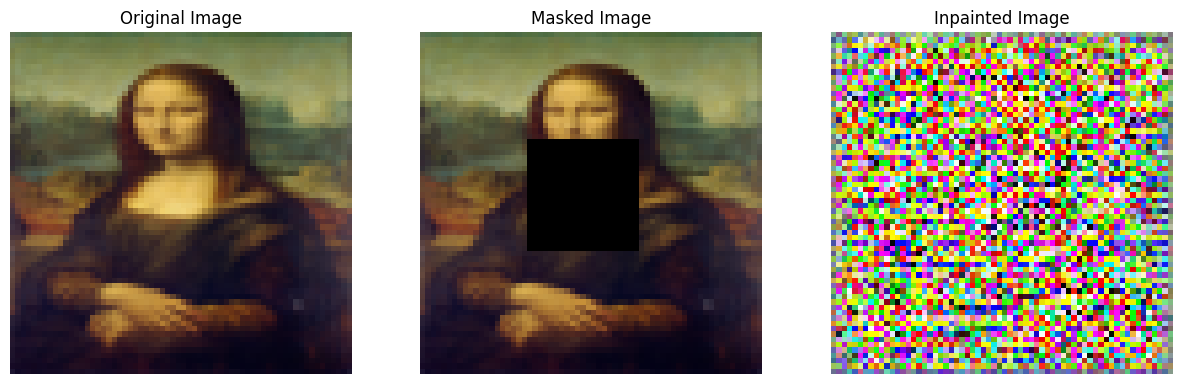

In [22]:
# Display original, masked, and inpainted images
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow((image + 1) / 2)
plt.axis('off')
plt.title('Original Image')

# Masked Image
plt.subplot(1, 3, 2)
plt.imshow((masked_image + 1) / 2)
plt.axis('off')
plt.title('Masked Image')

# Inpainted Image
plt.subplot(1, 3, 3)
plt.imshow(inpainted_image)
plt.axis('off')
plt.title('Inpainted Image')

plt.show()